<a href="https://colab.research.google.com/github/raj-vijay/mv/blob/master/12_Lab_11_Maximum_likelihood_parameter_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Lab11: Maximum-likelihood parameter estimation

**BACKGROUND**

<p align = 'justify'>In Lecture 10 we discussed the Gauss-Helmert-Model for calculating maximum likelihood parameter estimates using a model function. In this exercise you will further refine the algorithm developed in Lab06, Lab08, and Lab10 to find the optimal maximum likelihood estimate of the homographies and use them for stitching an image panorama that minimises reprojection error.</p>

**Task 1**

<p align = 'justify'>Use your solution for Lab10 and estimate initial homographies and inlier correspondences using RANSAC. Add a function to refine the homography estimates using the Gauss-Helmert model procedure to be implemented in the following tasks.</p>

**Task 2**

<p align = 'justify'>Make copies 𝒙𝟎𝒊, 𝒙𝟎𝒊′ of the correspondence observation vector 𝒙𝒊, 𝒙𝒊′ to be used as linearization point. Calculate the Taylor expansion matrices 𝑨 and 𝑩 of the model function as well as the current value of the model function 𝒈𝟎 at the linearization point 𝒙𝟎, 𝒙𝟎′
and 𝒉𝟎.
Also build the observation covariance matric 𝑪 and the current residual vector 𝒓 from 𝒙𝟎 − 𝒙 and 𝒙𝟎′ − 𝒙’ as outlined in Lecture 9.</p>

In [ ]:
import cv2
import numpy as np
import random
import copy

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
!wget https://github.com/raj-vijay/mv/raw/master/images/courtyard.mp4

--2021-05-05 16:44:07--  https://github.com/raj-vijay/mv/raw/master/images/courtyard.mp4
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/raj-vijay/mv/master/images/courtyard.mp4 [following]
--2021-05-05 16:44:08--  https://raw.githubusercontent.com/raj-vijay/mv/master/images/courtyard.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8180413 (7.8M) [application/octet-stream]
Saving to: ‘courtyard.mp4’

courtyard.mp4       100%[===================>]   7.80M  18.4MB/s    in 0.4s    

2021-05-05 16:44:08 (18.4 MB/s) - ‘courtyard.mp4’ saved [8180413/8180413]



In [ ]:
def get_tracks(filename):
    camera = cv2.VideoCapture(filename)

    # initialise features to track
    while camera.isOpened():
        ret,img= camera.read()        
        if ret:
            new_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        
            p0 = cv2.goodFeaturesToTrack(new_img, 200, 0.3, 7)                                    
            break    

    # initialise tracks
    index = np.arange(len(p0))
    tracks = {}
    for i in range(len(p0)):
        tracks[index[i]] = {0:p0[i]}
                
    frame = 0
    while camera.isOpened():
        ret,img= camera.read()                 
        if not ret:
            break

        frame += 1

        old_img = new_img
        new_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)        

        # calculate optical flow
        if len(p0)>0: 
            p1, st, err  = cv2.calcOpticalFlowPyrLK(old_img, new_img, p0, None)                                    
            
            # visualise points
            for i in range(len(st)):
                if st[i]:
                    cv2.circle(img, (int(p1[i,0,0]),int(p1[i,0,1])), 2, (0,0,255), 2)
                    cv2.line(img, (int(p0[i,0,0]),int(p0[i,0,1])), (int(p0[i,0,0]+(p1[i][0,0]-p0[i,0,0])*5),int(p0[i,0,1]+(p1[i][0,1]-p0[i,0,1])*5)), (0,0,255), 2)            
            
            p0 = p1[st==1].reshape(-1,1,2)            
            index = index[st.flatten()==1]
                
            
        # refresh features, if too many lost
        if len(p0)<100:
            new_p0 = cv2.goodFeaturesToTrack(new_img, 200-len(p0), 0.3, 7)
            for i in range(len(new_p0)):
                if np.min(np.linalg.norm((p0 - new_p0[i]).reshape(len(p0),2),axis=1))>10:
                    p0 = np.append(p0,new_p0[i].reshape(-1,1,2),axis=0)
                    index = np.append(index,np.max(index)+1)

        # update tracks
        for i in range(len(p0)):
            if index[i] in tracks:
                tracks[index[i]][frame] = p0[i]
            else:
                tracks[index[i]] = {frame: p0[i]}

        # visualise last frames of active tracks
        for i in range(len(index)):
            for f in range(frame-20,frame):
                if (f in tracks[index[i]]) and (f+1 in tracks[index[i]]):
                    cv2.line(img,
                             (int(tracks[index[i]][f][0,0]),int(tracks[index[i]][f][0,1])),
                             (int(tracks[index[i]][f+1][0,0]),int(tracks[index[i]][f+1][0,1])), 
                             (0,255,0), 1)

        # cut tracks that are too long
        # for i in tracks:
        #     if len(tracks[i])>50:
        #         keys = list(tracks[i].keys())
        #         for j in keys:
        #             if j<=max(keys)-50:
        #                 del tracks[i][j]
        

    # camera.release()
        
    return tracks, frame

In [ ]:
def skew(x):
    return np.array([[0,-x[2],x[1]],
                     [x[2],0,-x[0]],
                     [-x[1],x[0],0]])

In [ ]:
def calculate_homography_RANSAC(tracks, frame1, frame2):
    correspondences = []
    for track in tracks:
        if (frame1 in tracks[track]) and (frame2 in tracks[track]):
            x1 = [tracks[track][frame1][0,1],tracks[track][frame1][0,0],1]
            x2 = [tracks[track][frame2][0,1],tracks[track][frame2][0,0],1]
            correspondences.append((np.array(x1), np.array(x2)))
    
    print(frame1, frame2)
    best_outliers = len(correspondences)+1
    best_error = 1e100
    best_H = np.eye(3)
    best_inliers = []
    for iteration in range(1000):
        samples_in = set(random.sample(range(len(correspondences)),4))
        samples_out = set(range(len(correspondences))).difference(samples_in)
            
        A = np.zeros((0,9))
        factor = {}
        for i in samples_in:
            x1,x2 = correspondences[i]
            Ai = np.kron(x1.T,skew(x2))
            factor[i] = 1.0 / np.sqrt(np.sum(Ai.flatten()**2))
            Ai = Ai[[0,1],:]
            Ai = factor[i] * Ai 
            A = np.append(A,Ai,axis=0)
    
        U,S,V = np.linalg.svd(A)    
        H = V[8,:].reshape(3,3).T
                        
        count_outliers = 0
        accumulate_error = 0
        inliers = []
        for i in samples_out:
            x1,x2 = correspondences[i]
            Bi1 = np.matmul(skew(x2),H)
            Bi1 = Bi1[[0,1],:]
            Bi2 = -skew(np.matmul(H,x1))
            Bi2 = Bi2[[0,1],:]
    
            Cgg = np.matmul(np.matmul(Bi1, np.diag([1,1,0])), Bi1.T)    
            Cgg += np.matmul(np.matmul(Bi2, np.diag([1,1,0])), Bi2.T)    
            
            Cgg_inv = np.linalg.inv(Cgg) 
            y = np.matmul(Bi1,x1)                
            T = np.matmul(np.matmul(y.T, Cgg_inv), y)
            
            if T>9.21:
                count_outliers += 1
            else:
                inliers.append(i)
                accumulate_error += T
        
        if count_outliers<best_outliers:
            best_error = accumulate_error
            best_outliers = count_outliers
            best_H = H
            best_inliers = inliers
        elif count_outliers==best_outliers:
            if accumulate_error<best_error:
                best_error = accumulate_error
                best_outliers = count_outliers
                best_H = H
                best_inliers = inliers
                    
    inlier_correspondences = []
    for i in best_inliers:
        inlier_correspondences.append(correspondences[i])
    return best_H, inlier_correspondences

In [ ]:
def estimate_homography_GHM(observations, H):
    adjusted_observations = copy.deepcopy(observations)
    for iteration in range(10):
        A = np.zeros((0,9))
        B = np.zeros((0,0))
        diagC = np.zeros((0,0))
        g0 = np.zeros((0,))
        residual = np.zeros((0,))
        for (x1,x2),(x01,x02) in zip(observations,adjusted_observations):
            Ai = np.kron(x01.T,skew(x02))
            factor = 1.0 / np.sqrt(np.sum(Ai.flatten()**2))
            Ai = Ai[[0,1],:]
            Ai = factor * Ai 
            Bi1 = np.matmul(skew(x02),H)
            Bi1 = factor*Bi1[[0,1],:]
            Bi2 = -skew(np.matmul(H,x01))
            Bi2 = factor*Bi2[[0,1],:]
            Bi = np.append(Bi1,Bi2,axis=1)
            A = np.append(A,Ai,axis=0)
            B = np.append(B,np.zeros((B.shape[0],6)),axis=1)
            B = np.append(B, np.append(np.zeros((2,B.shape[1]-6)),Bi,axis=1), axis=0)
            diagC = np.append(diagC, np.array([1,1,0,1,1,0]))
            g0i = np.matmul(Ai, H.T.flatten())
            g0 = np.append(g0, g0i)
            residual = np.append(residual, x01-x1)
            residual = np.append(residual, x02-x2)
    
        C = np.diag(diagC)
        BCBt_inv = np.linalg.inv(np.matmul(np.matmul(B,C),B.T))
        AtBCBt_inv = np.matmul(A.T, BCBt_inv)
        N = np.matmul(AtBCBt_inv, A)
        n = np.matmul(AtBCBt_inv, np.matmul(B,residual)-g0)
    
        N = np.append(N, np.array([2*H.T.flatten()]), axis=0)
        N = np.append(N, np.append(np.array([2*H.T.flatten()]).T,np.array([[0]]), axis=0), axis=1)
        n = np.append(n, np.array([-(sum(H.flatten()**2)-1)]))
    
        delta_p = np.linalg.solve(N,n)
        delta_p = delta_p[0:9]
    
        lmbda = np.matmul(BCBt_inv, g0 + np.matmul(A,delta_p) - np.matmul(B, residual))
        delta_l = -residual - np.matmul(C, np.matmul(B.T,lmbda))
    
        for i in range(len(adjusted_observations)):
            adjusted_observations[i] = (adjusted_observations[i][0] + delta_l[i*6:i*6+3],
                                        adjusted_observations[i][1] + delta_l[i*6+3:i*6+6])
            adjusted_observations[i] = (adjusted_observations[i][0]/adjusted_observations[i][0][2],
                                        adjusted_observations[i][1]/adjusted_observations[i][1][2])
        
        H += delta_p.reshape(3,3).T
        H /= np.sqrt(sum(H.flatten()**2))
        
        print(np.max(delta_p))        
        
    print()
    
    return H

In [ ]:
def extract_frames(filename, frames):
    result = {}
    camera = cv2.VideoCapture(filename)
    last_frame = max(frames)
    frame=0
    while camera.isOpened():
        ret,img= camera.read()        
        if not ret:
            break
        if frame in frames:
            result[frame] = img        
        frame += 1
        if frame>last_frame:
            break

    return result

In [ ]:
def stitch_together(base_image, images_to_stitch):
    corners = np.array([[0,0,1],[base_image.shape[0],base_image.shape[1],1]])
    for image_to_stitch in images_to_stitch:   
        H = image_to_stitch[0]
        Hinv = np.linalg.inv(H)    
        x1 = np.matmul(Hinv,[0,0,1])
        x1 = x1/x1[2]
        x2 = np.matmul(Hinv,[image_to_stitch[1].shape[0],0,1])
        x2 = x2/x2[2]
        x3 = np.matmul(Hinv,[0,image_to_stitch[1].shape[1],1])
        x3 = x3/x3[2]
        x4 = np.matmul(Hinv,[image_to_stitch[1].shape[0],image_to_stitch[1].shape[1],1])
        x4 = x4/x4[2]
        corners = np.append(corners,np.array([x1,x2,x3,x4]),axis=0)
        
    top_left = np.min(corners,axis=0)    
    bottom_right = np.max(corners,axis=0)    
    size = bottom_right-top_left
            
    target = np.zeros((int(size[0]),int(size[1]),3),dtype=np.uint8)
    for i in range(0,target.shape[0]):
        for j in range(0,target.shape[1]):
            i1,j1 = int(i+top_left[0]),int(j+top_left[1])
            inside1 = (i1>=0) and (i1<base_image.shape[0]) and (j1>=0) and (j1<base_image.shape[1])
            if inside1:
                target[i,j,:] = base_image[i1,j1,:]
            else:
                for image_to_stitch in images_to_stitch:        
                    H = image_to_stitch[0]
                    x = np.matmul(H,[i1,j1,1])
                    i2,j2 = int(x[0]/x[2]),int(x[1]/x[2])
                    inside2 = (i2>=0) and (i2<image_to_stitch[1].shape[0]) and (j2>=0) and (j2<image_to_stitch[1].shape[1])    
                    if inside2:
                        target[i,j,:] = image_to_stitch[1][i2,j2,:]
                        break
                    
    return target

In [ ]:
def main():        
    tracks, frames = get_tracks("courtyard.mp4")
     
    H1,inliers1 = calculate_homography_RANSAC(tracks, int(frames/2), 0)
    H2,inliers2 = calculate_homography_RANSAC(tracks, int(frames/2), frames)

    H1 = estimate_homography_GHM(inliers1, H1)
    H2 = estimate_homography_GHM(inliers2, H2)
   
    images = extract_frames("courtyard.mp4", [0,int(frames/2),frames])

    cv2.imwrite("frame_0.png", images[0])
    cv2.imwrite("frame_1.png", images[int(frames/2)])
    cv2.imwrite("frame_2.png", images[frames])
        
    result = stitch_together(images[int(frames/2)], [(H1, images[0]), (H2, images[frames])])   
    
    cv2.imwrite("stitching_result_GHM.png",result)

In [ ]:
main()

120 0
120 240
0.002214591011826773
0.00889729366002838
0.0005884238567681515
1.3464546760830142e-06
2.419906850022794e-07
5.141041936027702e-10
1.0251152626974692e-10
2.2085553492640209e-13
4.4958860701650314e-14
2.0050553918078567e-16

0.002629240276600838
0.0005163840854721716
3.3197808419193643e-06
4.9140763591666335e-08
3.2506463444293975e-10
5.965503275322839e-12
3.603723441450884e-14
7.391943595757382e-16
5.611054645122423e-17
4.739932020070254e-17



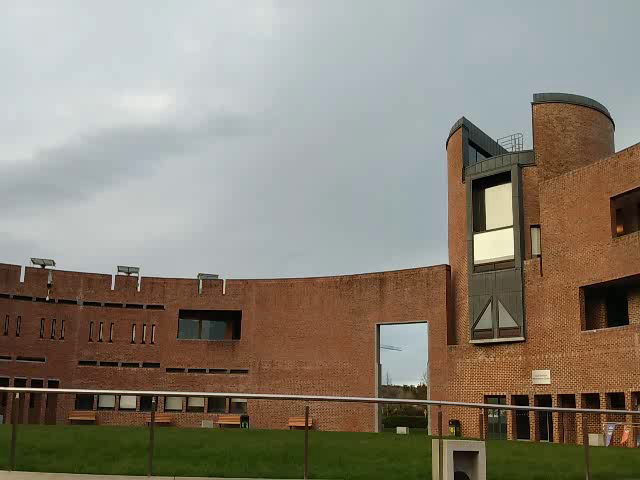

In [ ]:
frame_0 = cv2.imread('/content/frame_0.png')
cv2_imshow(frame_0)

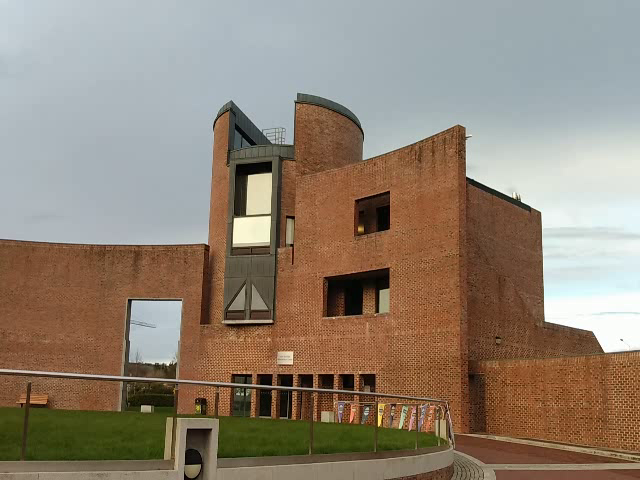

In [ ]:
frame_1 = cv2.imread('/content/frame_1.png')
cv2_imshow(frame_1)

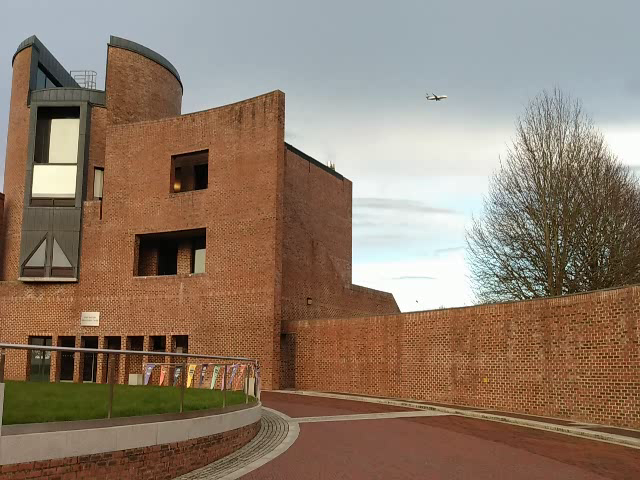

In [ ]:
frame_2 = cv2.imread('/content/frame_2.png')
cv2_imshow(frame_2)

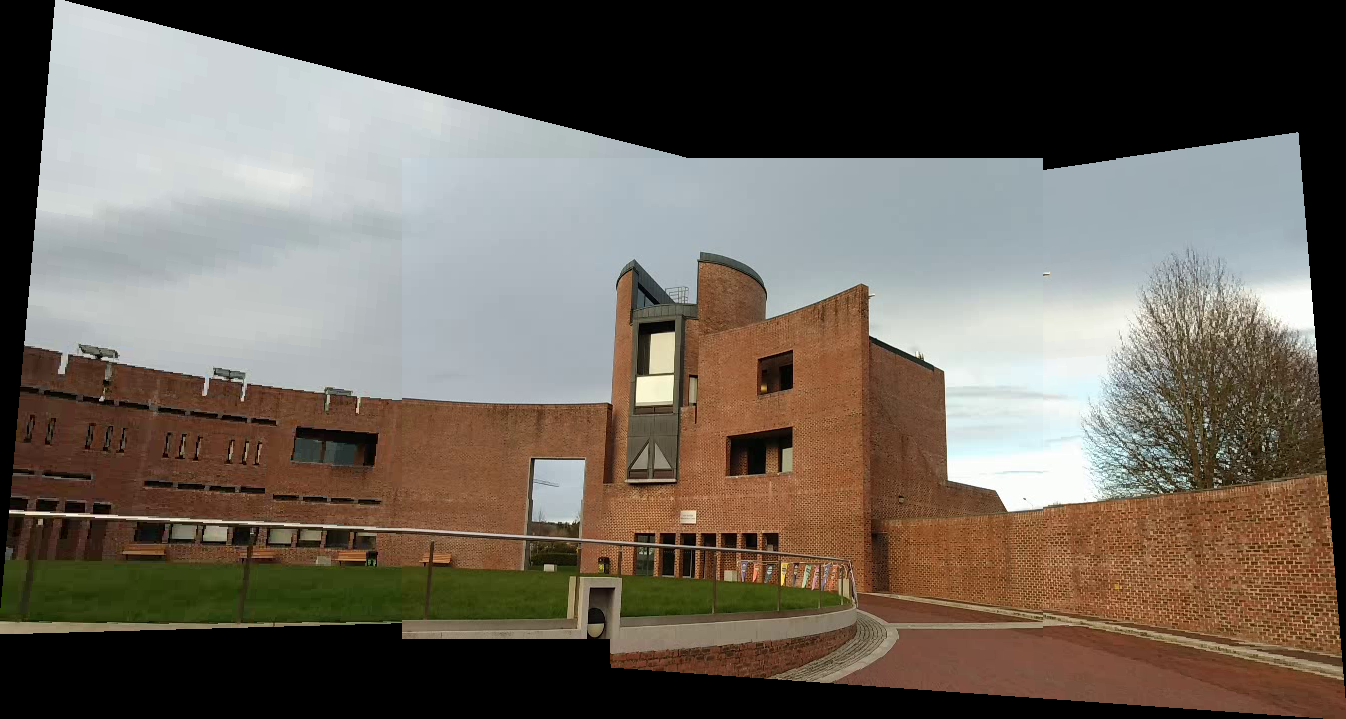

In [ ]:
frame_0 = cv2.imread('/content/stitching_result_GHM.png')
cv2_imshow(frame_0)